In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import technical_analysis.backtest_kz as bt
from technical_analysis.indicators import Indicators 
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

SYMBOL = 'SASA.IS'
SYMBOL_NAME = 'SASA Polyester'
SYMBOL_CUT = 'sasa'
scale = 1
range_list = [5,6,7,8,10,15,20]
range_list = [i*scale for i in range_list]
period = '2mo'
interval = '1h'
start_date = ''
end_data = ''
source = 'yahoo'

data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=False)
df_price = data.df.copy()

In [ ]:
ext_df = data.extract_features()

In [ ]:
import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer

client_twitter = TwitterCollection()
df_btc_tweets = client_twitter.get_tweets_df(SYMBOL_NAME, pathdf=f'../data/tweets_data/{SYMBOL_CUT}/', filedf=f'{SYMBOL_CUT}_tweets.csv')

tsa = TweetSentimentAnalyzer(df_btc_tweets)
df = tsa.cleaning_tweet_data(df_btc_tweets)
df = tsa.preprocessing_tweet_datetime(df)
df = tsa.get_sentiment_scores(df)
tsa.add_datetime_to_col(df)
df_result = tsa.get_sent_with_mean_interval(df, interval='1h')
ext_df = tsa.concat_ohlc_compound_score(ext_df, df_result)

Python-dotenv could not parse statement starting at line 11
[nltk_data] Downloading package stopwords to /home/kozan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Authentication Successfull


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
X = ext_df.copy()
X.reset_index(inplace=True)
X.drop(columns=['Datetime', 'feature_label'], axis=1, inplace=True)
Y = ext_df.feature_label.copy()
Y = Y.reset_index()
Y.drop(columns=['Datetime'], axis=1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=46)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

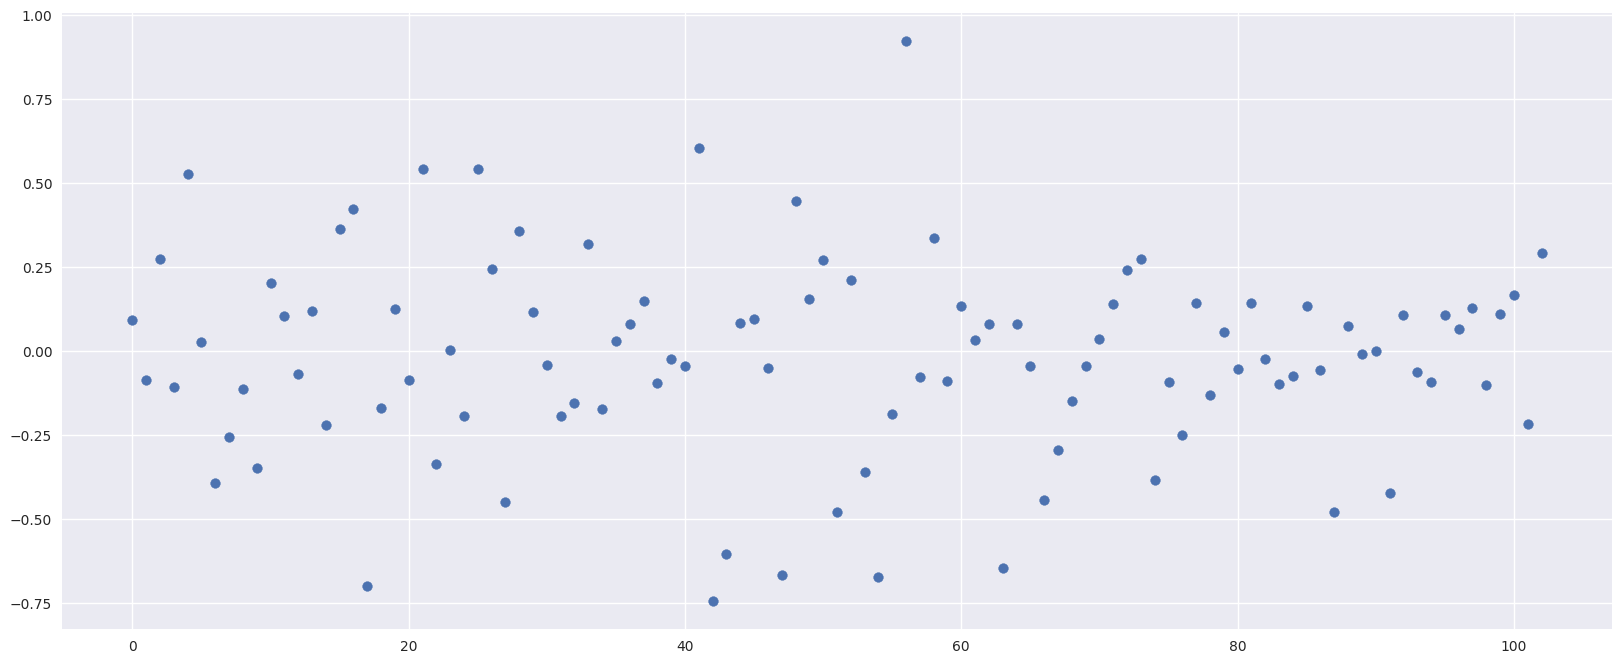

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
weigths = model.coef_
fig, ax = plt.subplots(1,1, figsize=(20,8))
plt.scatter(np.arange(0,len(np.column_stack(weigths).ravel())), np.column_stack(weigths).ravel())

In [ ]:
np.column_stack(weigths).ravel().size

103

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [ ]:
model = Sequential(
    [               
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ], name = "my_model" 
)   

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13312     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,193
Trainable params: 24,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train, y_train,
    epochs=40
)

Epoch 1/40
34/34 [==============================] - 2s 4ms/step - loss: 0.7005
Epoch 2/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6981
Epoch 3/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6947
Epoch 4/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6920
Epoch 5/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6918
Epoch 6/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6885
Epoch 7/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6853
Epoch 8/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6923
Epoch 9/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6832
Epoch 10/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6798
Epoch 11/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6830
Epoch 12/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6712
Epoch 13/40
34/34 [==============================

In [ ]:
pred = model.predict(X_test)
pred = (pred >= 0.5).astype(int)
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)
print(f'Confusion Matrix: {confusion_matrix(y_test, pred)}')
print(f'Accuracy Score {accuracy_score(y_test, pred)}')

9/9 [==============================] - 0s 2ms/step
Evaluate on test data
3/3 [==============================] - 0s 3ms/step - loss: 1.2647
test loss, test acc: 1.2646512985229492
Confusion Matrix: [[ 97  32]
 [104  37]]
Accuracy Score 0.4962962962962963


In [ ]:
pd.DataFrame(pred).value_counts()

0    201
1     69
dtype: int64

In [ ]:
# CALCULATE KZ_INDEX/SCORE
ext_df['kz_score'] = ext_df.sum(axis = 1)

Text(0.5, 1.0, 'KZ Index')

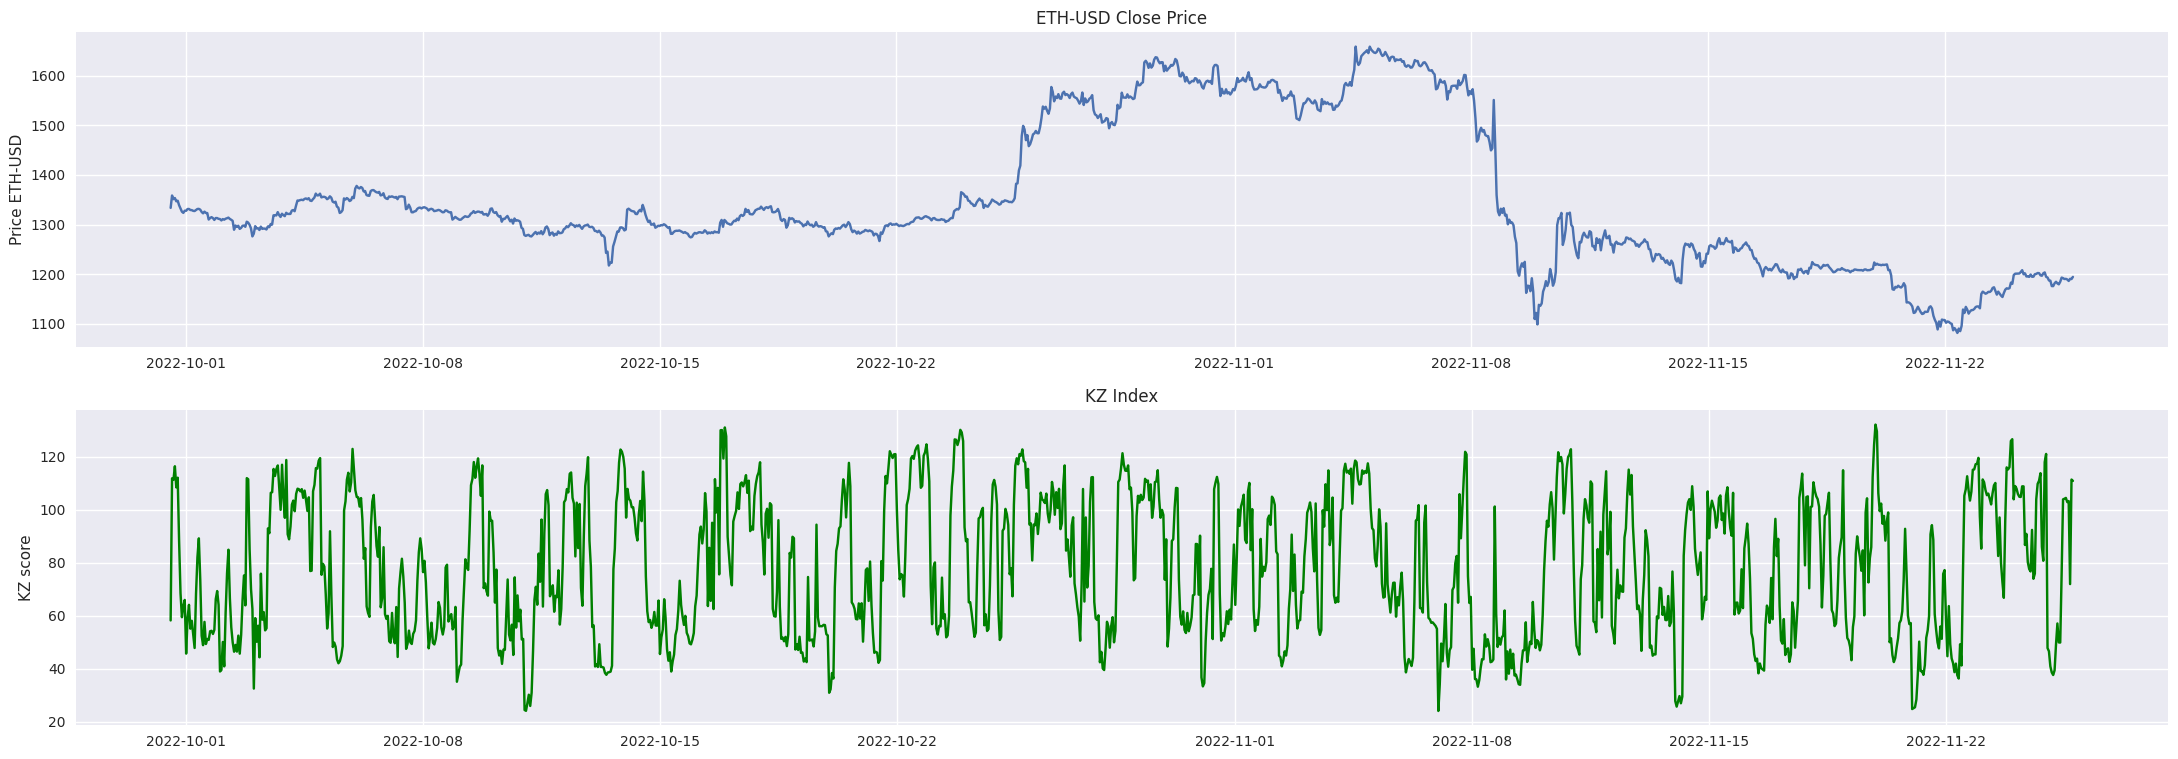

In [ ]:
kz = ext_df.kz_score
close = df_price.close

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(27,9))
ax1.plot(close)
ax1.set_ylabel(f'Price {data.symbol}')
ax1.set_title(f'{data.symbol} Close Price')

ax2.plot(kz, color='green')
ax2.set_ylabel('KZ score')
ax2.set_title('KZ Index')

Text(0, 0.5, 'Sentiment Score')

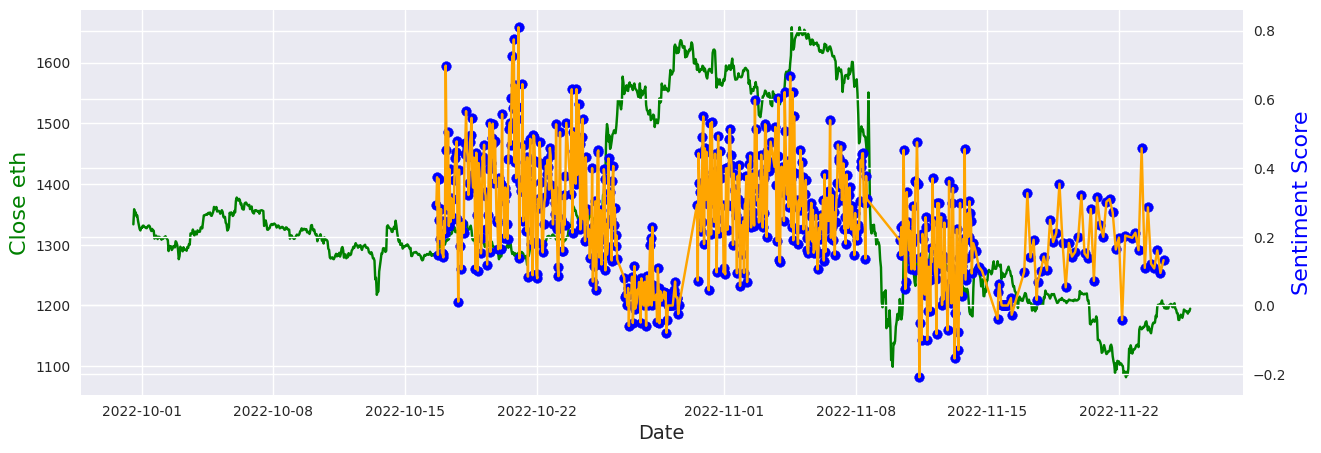

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_price.index, df_price.close, color='green')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel(f'Close {SYMBOL_CUT}', color='green', fontsize=16)

ax2 = ax.twinx()
ax2.scatter(df_result.index, df_result.compound_total, color='blue')
ax2.plot(df_result.index, df_result.compound_total, color='orange')
ax2.set_ylabel('Sentiment Score', color='blue', fontsize=16)